In [16]:
import torch
import numpy as np
from model import LIDCT, FCIDCT, FCCNNIDCT, DECNNIDCT, RESIDCT
import matplotlib.pyplot as plt
import cv2
from utils.jpeg import JPEG
from utils.metrics import psnr
# plt.style.use('dark_background')


In [17]:
#filename = "testset_50000_8"
model_type = "res"
modelname = f"res_jpeg_2400000_8_cv_dct"
outputimagename = f"res_jpeg_2400000_8_cv_dct"
jpeg = JPEG()
size = 8

In [18]:
train_on_gpu = torch.cuda.is_available()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# dctDataset = DCTDataset(filename=filename)
# test_loader = DataLoader(dataset=dctDataset,
#                         batch_size=3,
#                         shuffle=True,
#                         num_workers=8,
#                         pin_memory=True)
if model_type == "fc":
    model = FCIDCT(size=size)
elif model_type == "cnn":
    model = LIDCT()
elif model_type == "fc_cnn":
    model = FCCNNIDCT(size=size)
elif model_type == "decnn":
    model = DECNNIDCT(num_channels=64, size=size)
elif model_type == "res":
    model = RESIDCT(num_channels=64, size=size)

model.to(device)
model.load_state_dict(torch.load(f"./weights/{modelname}.pth"))
model.eval()
# test_set = load_file("data", filename)
print(model)
# print(len(dctDataset))

RESIDCT(
  (block1): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(8, 8), stride=(1, 1))
    (1): PReLU(num_parameters=1)
  )
  (block2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gdn1): GDN()
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gdn2): GDN()
  )
  (block3): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gdn1): GDN()
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gdn2): GDN()
  )
  (block4): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gdn1): GDN()
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gdn2): GDN()
  )
  (block5): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), s

In [26]:
img = np.float32(cv2.imread("test_image/0834.png", cv2.IMREAD_GRAYSCALE))
w = img.shape[1]
h = img.shape[0]
img = img[:h//8*8, :w//8*8]
cv2.imwrite("jpeg_result/0834_crop.png", img)
jpeg_recon = np.zeros((img.shape[1], img.shape[0]))
res_recon = np.zeros((img.shape[1], img.shape[0]))
for y in range(0, img.shape[0] - size + 1, size):
    for x in range(0, img.shape[1] - size + 1, size):
        mcu = img[y:y+size,x:x+size]
        quan = jpeg.encode_mcu(mcu)
        decoded_mcu = jpeg.decode_mcu(quan)
        ipt = torch.from_numpy(quan.reshape(1, 64, 1, 1)).to(device, dtype=torch.float)
        output = model(ipt)
        jpeg_recon[y:y+size,x:x+size] = decoded_mcu
        res_recon[y:y+size,x:x+size] = output[0].cpu().detach().numpy()*255

ValueError: could not broadcast input array from shape (8,8) into shape (8,0)

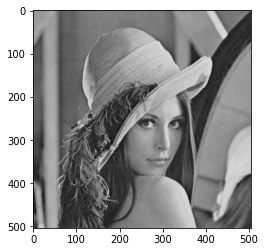

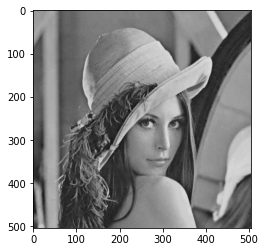

True

In [11]:
plt.imshow(jpeg_recon, cmap="gray", vmin=0, vmax=255)
plt.show()
plt.imshow(res_recon, cmap="gray", vmin=0, vmax=255)
plt.show()
cv2.imwrite("jpeg_result/jpeg_recon.png", jpeg_recon)
cv2.imwrite("jpeg_result/res_recon.png", res_recon)

In [21]:
import math
def psnr(img1, img2):
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

In [24]:
print(np.sum((jpeg_recon - img)**2))
print(np.sum((res_recon - img)**2))
print(psnr(img, jpeg_recon))
print(psnr(img, res_recon))

5431697.0
4871892.867770701
34.830058983514405
35.30243704102856


In [4]:
# img = np.float32(cv2.imread("test_image/0834.png", cv2.IMREAD_GRAYSCALE))
# # recon = torch.from_numpy(np.zeros(img.shape)).to(device)
# recon = np.zeros((img.shape[0]//size*size, img.shape[1]//size*size))

# for i in range(0, img.shape[0] - size + 1, size):
#     for j in range(0, img.shape[1] - size + 1, size):
#         #x = torch.from_numpy(dct(img[i:i+size, j:j+size], norm="ortho").reshape((1, 1, size, size))).to(device)
#         # x = torch.from_numpy(cv2.dct(img[i:i+size, j:j+size]).reshape((1, 1, size, size))).to(device)
#         x = torch.from_numpy(cv2.dct(img[i:i+size, j:j+size]).reshape((1, 64, 1, 1))).to(device)
#         output = model(x)
#         recon[i:i+size, j:j+size] = output[0].cpu().detach().numpy()
        
# print(recon[0])

[0.96831119 0.97512496 0.97017968 ... 0.80443615 0.81238699 0.8133918 ]


In [5]:
#test = recon.cpu().detach().numpy()
# test = recon
# print(test.shape)

(1352, 2040)


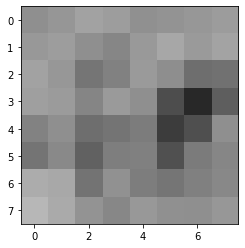

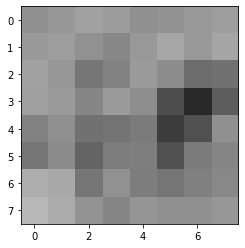

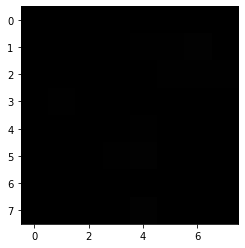

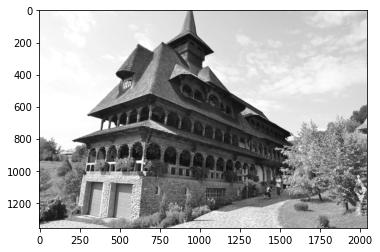

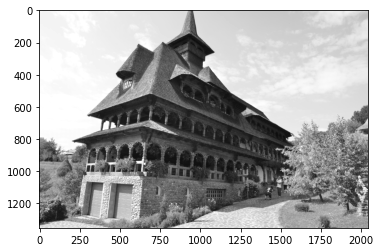

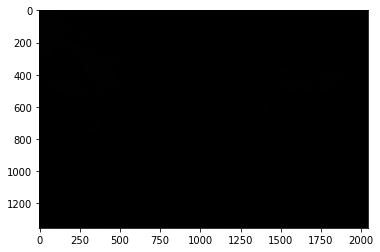

In [6]:
# print(test_set["y"][0].shape)
# norm="ortho"
# plt.imshow(test_set["y"][n][0]*255, cmap="gray", vmin=0, vmax=255)
# plt.show()
# plt.imshow(test_set["x"][n][0])
# plt.show()
# plt.imshow(idct(test_set["x"][n][0], norm="ortho")*255, cmap="gray", vmin=0, vmax=255)
# plt.show()
# plt.imshow(idct()*255, cmap="gray")
# plt.show()
# plt.imshow(output.cpu().detach().numpy()[0][0]*255, cmap="gray", vmin=0, vmax=255)
y_pos, x_pos = 288, 560
#fig = plt.figure()
#plt.plot()
#plt.imshow()

plt.imshow(img[y_pos:y_pos + size, x_pos:x_pos + size]*255, cmap="gray", vmin=0, vmax=255)
plt.show()
plt.imshow(test[y_pos:y_pos + size, x_pos:x_pos + size]*255, cmap="gray", vmin=0, vmax=255)
plt.show()
plt.imshow(img[y_pos:y_pos + size, x_pos:x_pos + size]*255-test[y_pos:y_pos + size, x_pos:x_pos + size]*255, cmap="gray", vmin=0, vmax=255)
plt.show()
plt.imshow(img*255, cmap="gray", vmin=0, vmax=255)
plt.show()
plt.imshow(test*255, cmap="gray", vmin=0, vmax=255)
plt.show()
plt.imshow(img[:1352, :]*255-test[:1352, :]*255, cmap="gray", vmin=0, vmax=255)
plt.show()

# val_one_epoch(1)

In [7]:
cv2.imwrite(f"./output/{outputimagename}.png", test*255)

True

In [8]:
cv2.imwrite(f"test_diff.png", img[:1352, :]*255-test[:1352, :]*255)

True

In [23]:
cv2.imwrite("gray.png", img[:1352, :]*255)

True

In [25]:
 img[:1352, :].shape

(1352, 2040)